## Reference
https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

**Note** The code is not exactly same. Dataset used is Flickr8k dataset.

In [1]:
#importing the lib
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

C:\Users\vipul\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#load doc into memory
def load_doc(filename):
    file=open(filename,'r')
    text=file.read()
    file.close()
    return text

filename=r"C:\Users\**\Desktop\jupyter\image captioning\Flickr8k.token.txt"
#load descriptions
doc=load_doc(filename)
print(doc[:200])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A lit


In [7]:
def load_desc(doc):
    mapping=dict()
    #process lines
    for line in doc.split('\n'):
        #split line by white space
        tokens=line.split()
        if len(line) < 2:
            continue
        #take the first token as the image id,the rest as the description
        image_id,image_desc=tokens[0],tokens[1:]
        #remove filename from image id
        image_id=image_id.split('.')[0]
        #convert description token back to string
        image_desc=' '.join(image_desc)
        #create the list
        if image_id not in mapping:
            mapping[image_id] =list()
        #store description
        mapping[image_id].append(image_desc)
    return mapping

descriptions=load_desc(doc)
print('Loaded: %d'% len(descriptions))

Loaded: 8092


In [16]:
def clean_des(descriptions):
    #prepare translation table for removing punctuation
    table=str.maketrans('','', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc=desc_list[i]
            #tokenize
            desc=desc.split()
            #convert to lower case
            desc=[word.lower() for word in desc]
            #remove punctuation from each token
            desc=[w.translate(table) for w in desc]
            #remove hanging 's' and 'a'
            desc=[word for word in desc if len(word)>1]
            #remove tokens with nuumbers in them
            desc=[word for word in desc if word.isalpha() ]
            #store as string
            desc_list[i] = ' '.join(desc)
            
clean_des(descriptions)

In [17]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [18]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions03.txt')

In [3]:
#load a pre-defined list of photo identifiers
def load_set(filename):
    doc=load_doc(filename)
    dataset=list()
    #process line by line
    for line in doc.split('\n'):
        #skip empty lines
        if len(line) <1:
            continue
        #get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

#load training dataset(6k)
train=load_set(r'C:\Users\**\Desktop\jupyter\image captioning\Flickr_8k.trainImages.txt')
print('Dataset: %d' % len(train))

Dataset: 6000


In [5]:
#load clean descriptions into memory
def load_clean_des(filename,dataset):
    #load document
    doc=load_doc(filename)
    descriptions=dict()
    for line in doc.split('\n'):
        #split line by white space
        tokens=line.split()
        #split id from descriptions
        image_id,image_desc=tokens[0],tokens[1:]
        #skip images not in the set
        if image_id in dataset:
            #create list
            if image_id not in descriptions:
                descriptions[image_id]=list()
            #wrap descriptions in tokens
            desc='startseq '+' '.join(image_desc)+' endseq'
            #store
            descriptions[image_id].append(desc)
    return descriptions

#descriptions
train_descriptions = load_clean_des('descriptions03.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))


Descriptions: train=6000


In [6]:
#loading features of training images set
train_features = load(open(r'C:\Users\**\Desktop\jupyter\image captioning\encoded_train_images.pkl', "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [7]:
all_train_captions=[]
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [8]:
#preparing a list of all the words that occurs more than 10 times in all the train caption
word_count_threshold=10
word_counts={}
nsents=0
for sent in all_train_captions:
    nsents+=1
    for w in sent.split(" "):
        word_counts[w]=word_counts.get(w,0) +1 
        
vocab =[w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [9]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [10]:
vocab_size = len(ixtoword) + 1
vocab_size

1652

In [11]:
#convert a dict of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc=list()
    for key in  descriptions.keys():
        [all_desc.append(d) for d in descriptions[key] ]
    return all_desc

#calc the length of the descriptions with the most words
def max_length(descriptions):
    lines=to_lines(descriptions)
    return max(len(d.split()) for d in lines)

#determine the maximum seq length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [12]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [13]:
# Load Glove vectors
#download vectors from :https://www.kaggle.com/incorpes/glove6b200d
glove_dir = r'C:\Users\**\Desktop\jupyter\image captioning'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [14]:
embedding_dim = 200

# Get 100-dim dense vector for each of the 10000 words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(1652, 200)

In [15]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [17]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [20]:
epochs = 20
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [21]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights_3/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 285s 142ms/step - loss: 4.1180
Epoch 1/1
2000/2000 [==============================] - 278s 139ms/step - loss: 3.4166
Epoch 1/1
2000/2000 [==============================] - 280s 140ms/step - loss: 3.1994
Epoch 1/1
2000/2000 [==============================] - 280s 140ms/step - loss: 3.0671
Epoch 1/1
2000/2000 [==============================] - 283s 141ms/step - loss: 2.9726
Epoch 1/1
2000/2000 [==============================] - 285s 143ms/step - loss: 2.9020
Epoch 1/1
2000/2000 [==============================] - 287s 143ms/step - loss: 2.8410
Epoch 1/1
2000/2000 [==============================] - 282s 141ms/step - loss: 2.7951
Epoch 1/1
2000/2000 [==============================] - 282s 141ms/step - loss: 2.7548
Epoch 1/1
2000/2000 [==============================] - 289s 145ms/step - loss: 2.7214
Epoch 1/1
2000/2000 [==============================] - 288s 144ms/step - loss: 2.6922
Epoch 1/1
2000/2000 [==============================] -

In [23]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [25]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights_3/model_2' + str(i) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 180s 180ms/step - loss: 2.4683
Epoch 1/1
1000/1000 [==============================] - 180s 180ms/step - loss: 2.4592
Epoch 1/1
1000/1000 [==============================] - 180s 180ms/step - loss: 2.4472
Epoch 1/1
1000/1000 [==============================] - 181s 181ms/step - loss: 2.4371
Epoch 1/1
1000/1000 [==============================] - 182s 182ms/step - loss: 2.4265
Epoch 1/1
1000/1000 [==============================] - 182s 182ms/step - loss: 2.4197
Epoch 1/1
1000/1000 [==============================] - 182s 182ms/step - loss: 2.4160
Epoch 1/1
1000/1000 [==============================] - 187s 187ms/step - loss: 2.4041
Epoch 1/1
1000/1000 [==============================] - 182s 182ms/step - loss: 2.3960
Epoch 1/1
1000/1000 [==============================] - 180s 180ms/step - loss: 2.3895


In [26]:
model.save_weights('./model_weights_3/model_30.h5')

In [34]:
images = r'C:\Users\**\Desktop\jupyter\image captioning\Flicker8k_Dataset/'

In [35]:
with open(r"C:\Users\**\Desktop\jupyter\image captioning\encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [36]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        #if word is None:
            #break
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

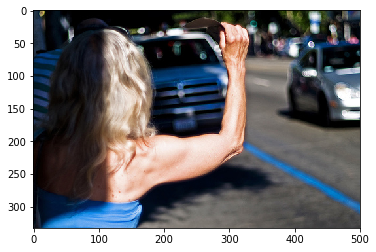

Greedy: man in black shirt and cast smokes cigarette


In [37]:
pic = list(encoding_test.keys())[0]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

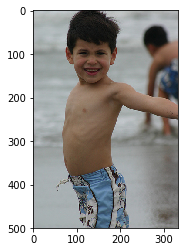

Greedy: young boy in red swim trunks is splashing in the water


In [38]:
z=0
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

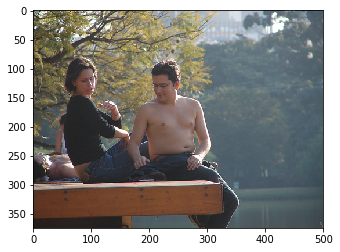

Greedy: man in black shirt and jeans stands on the street


In [39]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

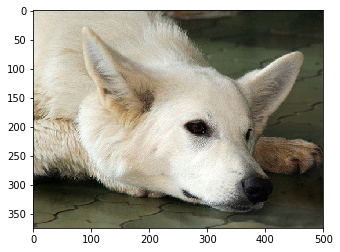

Greedy: dog is running through doorway of snow


In [40]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

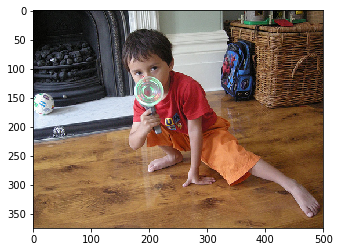

Greedy: young boy is licking his head whilst sitting on the ground


In [41]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

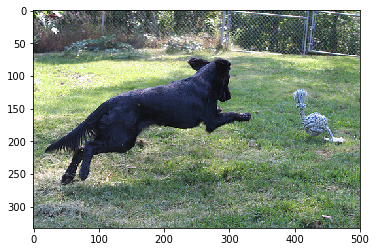

Greedy: two black dogs are running through the grass


In [42]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

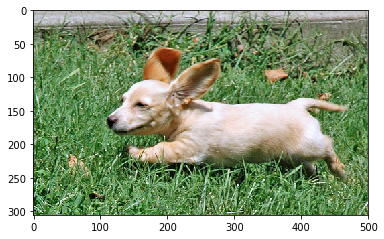

Greedy: two dogs are running on the grass


In [43]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

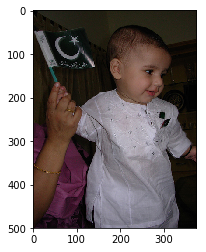

Greedy: young boy wearing red shirt is sitting on the floor with his arms spread


In [44]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

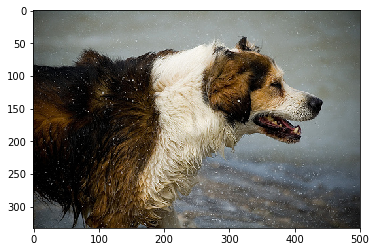

Greedy: dog swims in the water


In [45]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

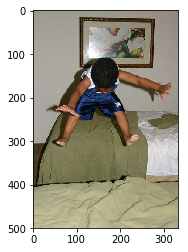

Greedy: two children are playing with colourful toys


In [46]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

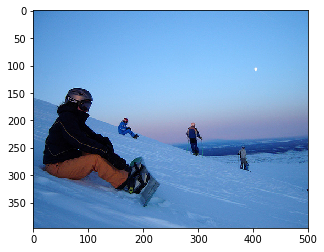

Greedy: two people are sitting on snowy hill


In [47]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

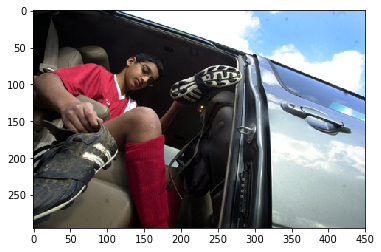

Greedy: man in black and white striped shirt is sitting in car


In [48]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

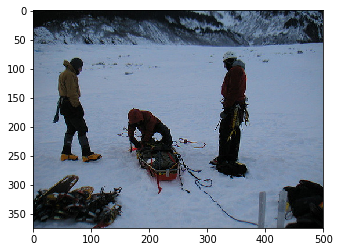

Greedy: two people are walking through the snow


In [49]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

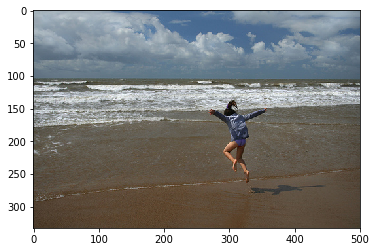

Greedy: young boy is walking along the beach


In [51]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

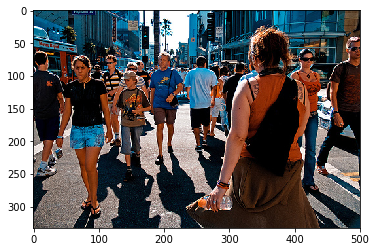

Greedy: group of people walking on the street


In [52]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

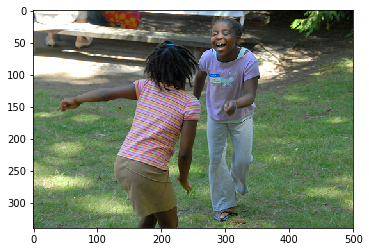

Greedy: two children are playing in puddle


In [53]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

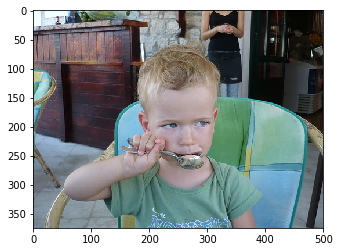

Greedy: baby in red shirt is sitting on red chair


In [54]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

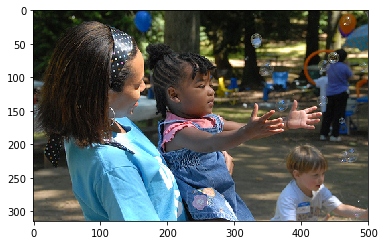

Greedy: two young boys are sitting in the bathtub of playground


In [55]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

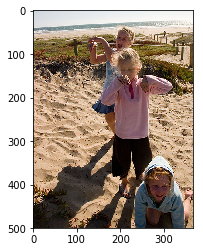

Greedy: two girls play in the mud


In [56]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

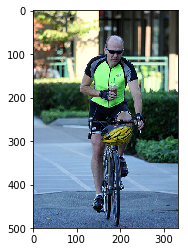

Greedy: man in red shirt and beard riding bicycle down the street


In [58]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

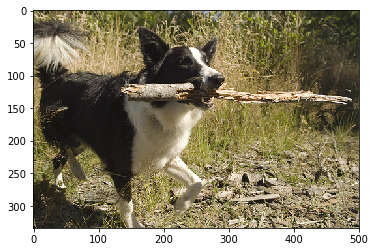

Greedy: dog runs through field


In [59]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

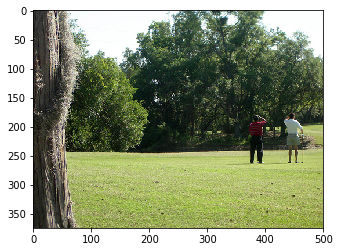

Greedy: man and woman are walking towards the camera


In [60]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

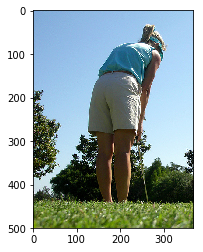

Greedy: little girl in pink shirt is walking through the grass


In [61]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

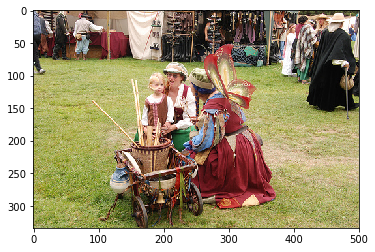

Greedy: group of people shop in the middle of the street


In [62]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

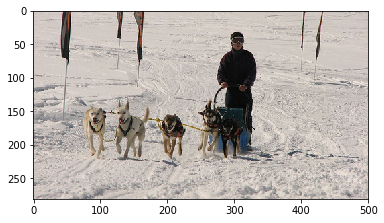

Greedy: man in warm clothing pushing cart pulled pulled four dogs


In [63]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

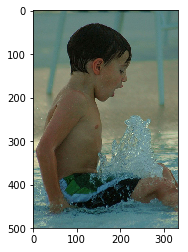

Greedy: child in red shirt is splashing in the water


In [64]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

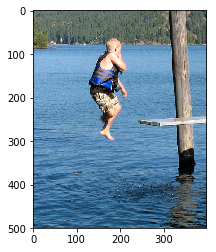

Greedy: two girls in boat on the beach


In [65]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

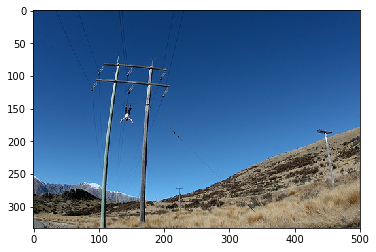

Greedy: man is helping another man ride bike on snowy trail


In [66]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

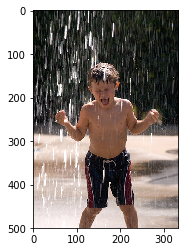

Greedy: young boy is running through the water


In [67]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

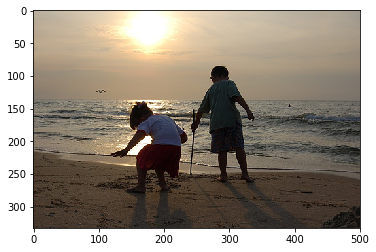

Greedy: two girls in the surf close to the water


In [68]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

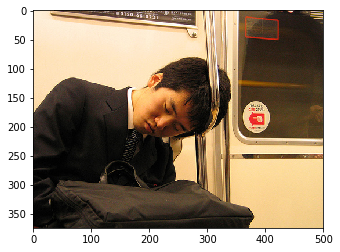

Greedy: man in black shirt is sitting in doorway with his arms around the subway


In [69]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

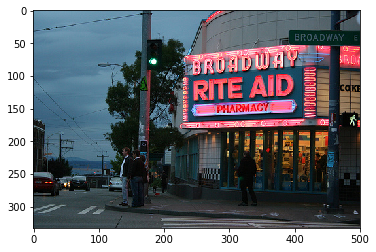

Greedy: man in red shirt is standing in front of red truck


In [70]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

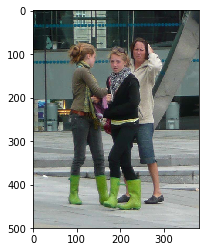

Greedy: woman walking down the street


In [71]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

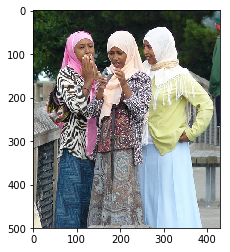

Greedy: two women in traditional costumes stand before the


In [72]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

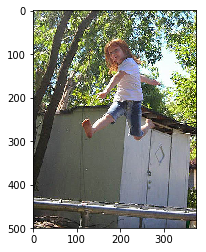

Greedy: man in black shirt and jeans is doing trick on his skateboard


In [74]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

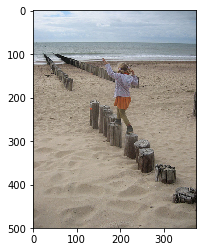

Greedy: two girls are standing on the edge of the road


In [75]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

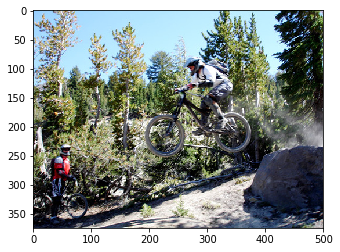

Greedy: man in red outfit and helmet biking through wooded area


In [77]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

* Model clearly have some obsession with 'red' and 'two' .